### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

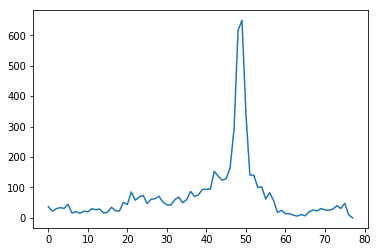

In [1]:
import numpy as np
import matplotlib.pyplot as plt


n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "11":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
#np.set_printoptions(threshold=np.nan)

plt.plot(reporting_matrix.sum(axis=1))
plt.show()

78
0.042977530803083634


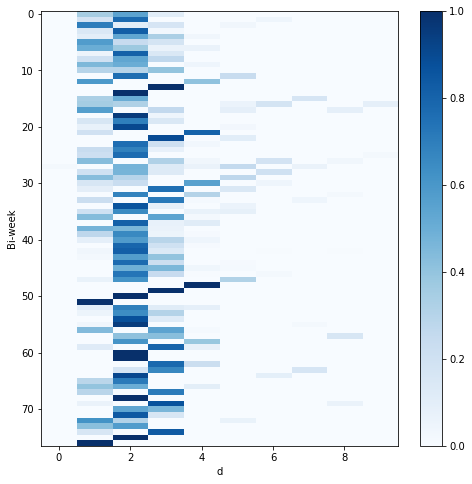

In [2]:
print (len(reporting_matrix))
D=10
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d[:-1]
p_hat = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat.append(n_t_d[i]/np.sum(n_t_d[i]))
    
p_hat = np.array(p_hat)
print (np.var(p_hat[:2]))
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

/Users/gcgibson/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in divide


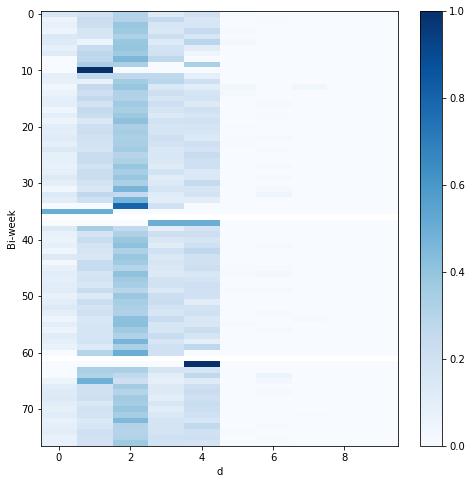

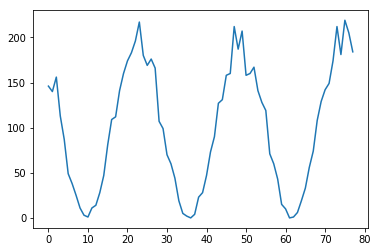

In [3]:
# list for holding simulated data, length 260
arr_list = np.zeros(260)
# iterate over season  
for s in range(10):
    #iterate over biweek per season
    for t in range(26):
        season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
        e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
        arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 

# plot simulated data to make sure it looks like ID        
ts = arr_list[:100]

p_vec = np.random.dirichlet(np.append([50,100,200,100,100],np.ones(D-5)),size=1)[0]


sim_n_t_d = []
for i in range(78):
    tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)    
    
p_hat_sim = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat_sim.append(sim_n_t_d[i]/np.sum(sim_n_t_d[i]))
    
    
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(sim_n_t_d.sum(axis=1))
plt.show()

In order to simulate delayed data we first randomly simualte the delay proportions from a dirichlet distribution

If the true delay distribution is given by 
$$p_0,...,p_{9} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

we can interpret $p_i$ as the percentage of cases that were delayed by $i$ days.

In [4]:
import numpy as np
season_data = []
arr_list = np.zeros(260)
for s in range(10):
        #iterate over biweek per season
        for t in range(26):
            season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 
            season_data.append(arr_list[(s-1)*26+t])
    # plot simulated data to make sure it looks like ID        
ts = arr_list
from pyramid.arima import auto_arima
stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
future_forecast = stepwise_model.predict(n_periods=26)
print (future_forecast)

/Users/gcgibson/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2204.985, BIC=2222.789, Fit time=1.907 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2208.262, BIC=2222.505, Fit time=0.843 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2263.525, BIC=2277.768, Fit time=1.170 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2165.365, BIC=2186.729, Fit time=2.696 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=2211.632, BIC=2229.435, Fit time=1.499 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2156.347, BIC=2181.271, Fit time=4.426 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2151.481, BIC=2172.845, Fit time=3.786 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=2161.743, BIC=2179.546, Fit time=2.747 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

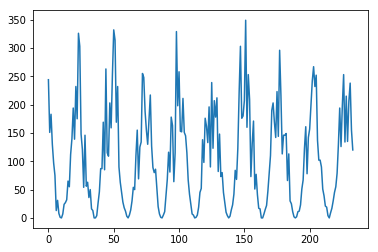

KeyboardInterrupt: 

In [5]:
from scipy.stats import poisson,nbinom
from scipy.optimize import minimize
import matplotlib.pyplot as plt

import numpy as np
r=10
def process_model(data,n_ahead):
    def neg_loglike(theta):
        nll = 0
        for t in range(len(data)):
            e_y = theta[0]*np.cos(10*(t+np.pi)/(13*np.pi)) + theta[0]
        
            nll += -1*poisson(10*e_y).logpmf(data).sum()
        return nll
    theta_start = np.array([1])
    res = minimize(neg_loglike, theta_start, method = 'Nelder-Mead', options={'disp': True})
   
    theta_hat = res['x'][0]
    print (theta_hat)
    forecast = []
    for t in range(len(data),len(data)+n_ahead):
            e_y = theta_hat*np.cos(10*(t+np.pi)/(13*np.pi)) + theta_hat
            forecast.append(np.mean(np.random.negative_binomial(r,r/(r+10*e_y),size=1000)))
    return forecast



arr_list = np.zeros(260)
        #iterate over biweek per season
for t in range(260):
            season_effect =10# np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[t] = np.random.negative_binomial(r,r/(r+10*e_y)) 

    # plot simulated data to make sure it looks like ID        
ts =arr_list[:len(arr_list)-26]
plt.plot(ts)
plt.show()
plt.plot(process_model(ts,26))
plt.plot(arr_list[len(arr_list)-26:])
plt.show()



In [6]:
import emcee
from scipy.stats import binom
from scipy.stats import norm
import pymc3 as pm

def bayes_estimate(p_vec,process,process_var,partially_observed,scale_factor):
    basic_model = pm.Model()

    with basic_model:

        # Priors for unknown model parameters
        n_t_inf = pm.Normal('n_t_inf', mu=process, sd=np.sqrt(process_var)/scale_factor)


        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Binomial('Y_obs', n=n_t_inf, p=sum(p_vec), observed=sum(partially_observed))
    map_estimate = pm.find_MAP(model=basic_model)
    return map_estimate['n_t_inf']

/Users/gcgibson/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


260


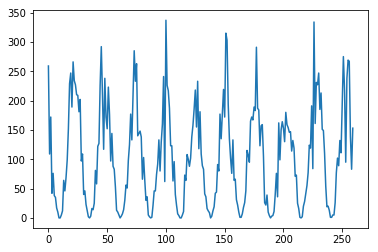

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Optimization terminated successfully.
         Current function value: 4783949.451744
         Iterations: 23
         Function evaluations: 46
10.002441406250023


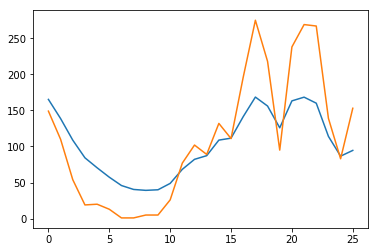

INFO (theano.gof.compilelock): Refreshing lock /Users/gcgibson/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
logp = -inf, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 547.63it/s]
logp = -137, ||grad|| = 5.1241: 100%|██████████| 8/8 [00:00<00:00, 1730.77it/s]
logp = -265.99, ||grad|| = 5.4198: 100%|██████████| 9/9 [00:00<00:00, 1615.82it/s]
logp = -340.01, ||grad|| = 5.5388: 100%|██████████| 10/10 [00:00<00:00, 1590.86it/s]
logp = -249.1, ||grad|| = 5.3029: 100%|██████████| 9/9 [00:00<00:00, 1472.78it/s]
logp = -217.58, ||grad|| = 5.1864: 100%|██████████| 9/9 [00:00<00:00, 2258.51it/s]
logp = -232.36, ||grad|| = 5.142: 100%|██████████| 9/9 [00:00<00:00, 2169.22it/s]
logp = -203.08, ||grad|| = 5.1063: 100%|██████████| 9/9 [00:00<00:00, 1578.12it/s]
logp = -166.08, ||grad|| = 4.9805: 100%|██████████| 9/9 [00:00<00:00, 1508.02it/s]
logp = -165.63, ||grad|| = 4.8567: 100%|██████████| 9/9 [00:00<00:00, 1922.23it/s]
logp = -85.542, ||grad|| = 4.179: 100%|

model 2
[165.27  39.85  51.36   5.73  13.65   1.23 -10.08 -15.33 -15.84 -14.29
  11.19  68.38  82.21  86.45 108.85 111.62 141.36 168.5  156.08  54.91
 163.23 168.38 160.03 114.03  53.35 118.53]
model 1
[149.   108.14  54.12  19.06  20.07  13.06   1.01   1.01   5.03   5.03
  26.19  77.6  101.83  87.73 131.3  112.15 196.07 276.96 218.55  93.22
 241.22 268.75 257.18 140.16  51.42 194.52]
truth
[149. 110.  54.  19.  20.  13.   1.   1.   5.   5.  26.  77. 102.  89.
 132. 111. 196. 275. 218.  95. 238. 269. 267. 139.  83. 153.]
process model
[165.26562268 138.71586374 108.79729003  84.30970101  70.48806192
  57.44344875  45.89064797  40.44690366  39.20686441  40.0052957
  48.84365647  68.37548287  82.2069596   87.27557418 108.84934165
 111.54584893 141.35756565 168.50211839 156.08422242 125.90150128
 163.22849924 168.3846124  160.02704486 114.03233953  86.61719485
  94.57282754]


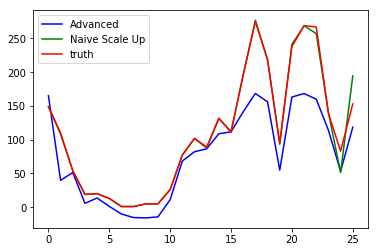

------
1723.910400000001
1188.1808999999998
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.
Optimization terminated successfully.
         Current function value: 4842853.967683
         Iterations: 24
         Function evaluations: 48
10.111230468750017


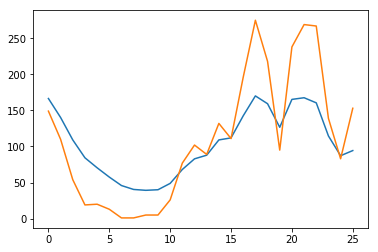

logp = -inf, ||grad|| = 0: 100%|██████████| 2/2 [00:00<00:00, 748.52it/s]
logp = -138.79, ||grad|| = 4.9767: 100%|██████████| 8/8 [00:00<00:00, 1737.67it/s]
logp = -261.76, ||grad|| = 5.3134: 100%|██████████| 9/9 [00:00<00:00, 2006.74it/s]
logp = -333.17, ||grad|| = 5.4319: 100%|██████████| 10/10 [00:00<00:00, 2016.49it/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/gcgibson/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
logp = -243.96, ||grad|| = 5.2004: 100%|██████████| 9/9 [00:00<00:00, 1360.95it/s]


KeyboardInterrupt: (None, <type 'set'>, ([(((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('de5885273f4359a880239beef6ca0db6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('89c79a06d5f7165238e090313d38c7ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('747118e897893ef50f3ab7755a25391e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0a39bc7a4c5feaa2bcbf15c567d632d0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b5e9a17b90bdc29fdfb7ad51ec0c2528', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('25bcf1eb59e2cffc82ae0831de29d1e5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5d84d4022df4e10ba6f2fd9ee4303651', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0b2e774d716cdd499266b2c482f0efca', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c47f76835c275f8cd8da36a353b24558', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b0307940bafcd8f82a2150bf42c8762f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('7408a4fc03006f7c6751af1241c02581', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60eee1991952d995e8ea08cd0b5a7804', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('772ef84a82ac9c2e1c4d550cad0d1c46', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2922a08895a9a7369397f3bc5c369ceb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d5f5fa1444aed8c5afdab914fce96d18', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d188180fc2786c521e1a583d9f4619f9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('98cb1ff350ba2a08bb12cac59a609923', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0862bd6c46b2ba220246856fb8adce4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c4e57b48f0a0447bc97ed728708bab62', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('61c2c90f4f70a777ef94ec21044c1abd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2fa09999a8213f32cd7142ec30b3c7eb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('564531e774445dc607fa5cb0ad8673ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('80ef5ee2d2bba0bcb566e53a6d821c74', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('274d960e189b1b6b0a83e84b1e66c546', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b373b281817f97e7660b53f39e2f6689', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c91dc07a7cf70f957477c9e9366961a7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('bf00aa99f12cc5b9b2941eafbd683053', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('5d47ff3462a6ab40948eff80cf8c8c80', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('22d707ecb7deb94f241320f8e8f3c351', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2dbcd90f4d987e64e3ec5f60840ad4d9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('503201aac03d3bb1cd58a26cf3380995', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1f16617680e54e71a0be126c3c359e4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('6bb61093dd10ac62bbfac032a4e50c6f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9eb241090f636af659886adb5b5c7780', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c05c7ca369ecb3a36a4ebdd31316ae5b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('44b43901856dfde1acb310ed8f6ca417', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('282339c9d89248b6db4205fa860a6885', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('180f1e68bfb6771fe1340de6fe473150', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c6af012065c5e3804392ee987894b9d9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a8d62fbb1a2221ba49d6ae665975a667', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('251752ba8933b20076020b4045c2d68b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d09897a16dacfffd442f35b583e6ae3a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('15ca198ad35608bbddd7211cc9ce4c31', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e31df895ebeecd1641ff778dd2f4130f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b8fa06d634379b27acda5f1c8e4e4c47', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5e0eca4d85da499f8ba703a3805389cb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('87ece0789f18dbca74e4447f29cdb853', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aa6eb37bce0118ea47530562c7160d4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cf84953ec7f83d959d5a030a5623ae9e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0cdff4c37f1eefa652b0bbdfb485e841', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6d11a6f248f6c36d6bf1854de95e2254', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d342e31b311e76caacace4367fe18304', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('f694358dbc7882339ae04b0b32fa9b51', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('34f27dc1526de8d66e55fd9a8353ce80', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6f561fee8c45d7c75a9575a0688e9aa3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('53819fde121c04be5147db64a26d5ced', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('275fe3d1cedff9d6b65e1b5f427585d6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('28294439130451733b0f97f43289ffe4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('da22d05327f7fc4585b73ec1448b918e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('beff2ce0c87215e1b6657c9fb3ee35a3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7c3c37581ff4837572573479b40e5b6d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('4bbe86581e40833a25f4ce00105342de', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f8b77a2077bb3c44eacb7d1fa98444e1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1e3aaa28d740471aed56404471a5666e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bb94da091adbbfc68175d0be3cad7e8b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('886a1a989a63c99a5bc7a607b784622a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e9182b2d529ad09fc029d2107417bb0d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d22b5a33c8daab216741cbe60182aef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('70c64d4037fa3d326c55cf0e08f2e976', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6f7a34493f13bc8b87b7fd141f6e4c71', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cafa60c74c3dfa37b4321b8c66e56c67', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1e44be990f6254317981285f11e7fc11', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ef2f088416e1ba089915e63577eb4aba', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('30200730b367635ec27108df9e3360d2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('edb72e857dcaf1daeb154a3668443e57', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('fd5f4dcd094592e3b23890746d479116', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5e49215bd38c620d52a865c4fdfbc1f0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0d38c901882cd078a8fe7066bcfc7604', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ae56b29c400cd98a3ed000eeef0c82f2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6019d3b9a5505a0765b2bff24b7da97f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4f48711b2c5920aa9be1b5a3b35ef631', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('52094b6dc94ce0765b84cb508483d8d4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('8b86f8bc883a05c46ffa4855b16543ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ac627ddf3c59c1ee741feff007bb2b35', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('970ed8c90a5ed83abd3b598751c5045e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3e7f965f9bb44d266a0677c1d1fe9331', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0ff439816da329bed74066f0aaff3c51', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f84465dd4d451cd7d58596154b3f8842', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1133293e883708f22a8fe9dcf92038d1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('88bd5f8975ab6321ed6fd549ec7140cd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9bc18f4c042ddb8018e41d78607a2af0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aad2348cf5ccbcc009cca0e8265f7d13', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bef3511845331839a84899661308d842', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0fca6b2f17890d558dc6cf24b38570ce', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ba7fd01211a1bc57b79a087ba02a24ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('56ed9708b94b16998731f491dc33ee1b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6bfd56b320cf9761abeb90f5414c1fdd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c7fcc9064aa7e7544b854a5ae23d4b27', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5d8177c0e1228abe9ecb4f914790bb79', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('98969dddd7af04a4e12f672539814121', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9ec2be44866dbe48d53404493a84a896', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('24656fda5add15b6ab07dd417971f4de', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c3817fbbc82ca29accbe55e69b9380e1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5f528b1ec1999bb1f7c8dcad92dbfa7e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('013dba3d980c061de83880c986e476a7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5d9b69143fbdbd887afa9dc0c20a4a65', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('170cedc3d9bbc9f1dfba7d1f121f600f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c542a36e257b5f2057d803154b815a20', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1528ddacd8a84d02fc07def36258ac12', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('69e0547b8b4fa6946ab74506df98ade2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8e85bf205c79378fbea0cb9e74852bc4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('83c99a44be2a91efd70f9cf6e19ff4dc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('fb76ada3c392fc829a09e9862fdcbc67', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('b74091d5327c46460bdc177e0e08dcdc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2d349c44072c58c7bb5e3406780548ec', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f1621a44a553af41981eb21b46bf47f9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('283cd7eb130d12d1f06bf6d0e16279df', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('240739f66b5408bd9b6dd9cbff9a729d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('7f4495b566fae7d04a0f5cdb14be1954', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('c8282f04cb37c995bd1c8ecb7834b166', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('301dd952b4b1c8ca0fe04165d7f1f3b2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4481148c209ecab9e9fd4f1317a8faf5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f6fd94f2c6e5390d0bea9948074267ec', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5ce777bd32ba27e27cd14d895f25ed46', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a8e522c87248c294b0041bbe9ead7b37', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a66a38e9cdd8111ef415b92d60b91368', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8fa46212663947de8b4d44b57d7b61bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5a450a9ea323af82c655970cb89d9fec', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2c8f9b2a352b25d7e910f763a72cb4e0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('06b17d8c92fab5f4cda1c265a34c4e06', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c946767d699ee7bd30ef64415d24bc11', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2807bed8918ad1f46ba4e0263ba11228', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9db5743252492f95703292cafa41916f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('57cc554e6b55fd4edf0c87119dfd327e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c1523f8a80e7ec99e8773852acac7f25', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('14ca6b1ed9ef034bcc6580af35976eac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e262ba870007374cdeb1d2c06e9b753a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f7002908a298150b3ee37f1882138bc7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e9037561de07e08776a5d5617c8b2711', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('982d581297678be38c47bdbbabffc06a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c32e466d4e43cc32f4fb982873bdd759', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c4a9553886791a048f54d7e269c9e85c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4034bbc2ae9d8412b9335cc447d62f78', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dbd06c47fa42f3dd7ec5230595630e64', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0910b0b55df49fefae484586a09bff0c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('8293fb53581ba3dcb6ee2643aad58347', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f9f86401f0ad0b5d4b3e1d978d18f760', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0e0ffddc305172fd7f29f5777308bb89', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4584e44760019c223be7cdc64e9d4e49', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('396128b9436c981acff969885abfbd2d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('41dbffa69f7fcfc9fd0248cf1088a76b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0fc53756864d30f50b03eff4d926c17e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0e54ea6307afafda276cc62f61cc9e0b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4797e1f83ed0f52d986ae88b67ed9fcf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aa0d57e4df17ea3a513259bfd07978b6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d853d2d676c05761f62cd33cecb10426', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c6714340e174efc1790c02de83200554', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('35434c0f8004c4d2c56de584c8cf5b24', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d440d96dc93ac1d28c9093d2254f3e47', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f58fa4ea14c903e2f27e12286609cc57', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2aebcdc3eb531afc64a6f82bc20babca', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f2181928f2c4957a798e8703d4a74d1c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('73810e2484a2e5e4185a4967deda147a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a1fe6515ffae91de02dc528376699d0e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f1b5dd91c2ee8f2cb27da418730cd591', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4c1da88a9df699ba5fe00dc34bef93b2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60630328b9ad0a709ae2060ee7f0e336', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7c232b938cac1833b22c80d6f3696188', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f5b774ec0785aad8555d0201e6a3ec92', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5321330bd9ca4d930b4e3c89c216ada8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1cee86992225ac3d2fdcf558c168152a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dd2fc52b119a1184e394a6078ac1bfed', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('dc6c1c3d86d24d602997232ef261d68d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('79a9c04ec2591d1ea2ec72aa2077a2a6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ec05b2fcb2059d66a311fde886906067', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5c1beba801a29d9f9dbdda743a7f0926', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('46ff9c38668c90fe6761b486a0ae9caa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6ad888168dea41a320aaff7d51a1a594', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9fed71f41d7ddaddc12f9ba1a919ab8f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('45816fc58e6fabc053802fe0b48d3689', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7279239b36f07a0b79f3095560577f0c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f43d97dd69c0da7b37751d7620adccd1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('71de5421d7f3ac9d285603969d8306c4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('be29086de2b1f58a72be73272830d933', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('00135cf01ebfc2a3497e9e0effc6cf91', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('554f88707451c5097db95a096f0890bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('31e162b63b12ece12d830707b0955886', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b24a0d6d1c65d15907d25c1569d72787', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fdf5d5fb6ce24fd297e44dcba6690939', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9a86349233a439c4bf73668462c04e17', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('97b9c27f3096d7e60f9640bbcc8d609d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dc9f708e0ccf8b3600e5ad94d6650a34', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('488a88157d8d260dd961544443730c04', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('61c113747b1bd8f6c274cbcd45e2c463', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('cbebd24b847fd13abdb758de4a614135', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('42aaf5672c2ecca175f30199f5817108', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('00e26a96602157e70b750470ec5f5b7d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('60c1992bbd88ec7e7cd32c76b7757738', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e5f4c60027c04ea1018abeaad786d9dc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2bc829c61daa33f4a251ca0c6f64e99a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5d1d2089899173a1d89886cf64a891d1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e1ec712d386a2c82658549183f57af39', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cc93ce426a1125caddcc855a0ce9288f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3c671b27a467903c89662ec9fd7ae9a2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3f2bcff1f6987613b306fd52224c5b48', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('80111fd00f19a37bc588fe4611f67c7b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('807897562f4f60f5a2cf1fb452afaeea', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('523593883b07a6a8bcce3f2d777603c7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5231349bc871a7f01ffff889ff60bb68', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('da9de7280c62df9f22c96f2797be5971', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f9d59dba5f4ddf17a2283297c5c02f7e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0c6d7929ca2a891b439ef56c9ac51abf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('94ae42257c3356e45251f3123c26d594', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c967239011b17f217df1b37b1ea464ef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ebf562b173b4ea81e5879a36d2f24b3b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('99b820f06ff7ee1c38f9c6582164c5bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('96bca032166237a56f1ef3cc9bc83da6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7f0cca308c30e53e3a2319a03203e3fe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cf42e8566f91c5d3f28b3ebf8d5b5c72', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('bb049a534e411233626435acadb8b196', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e9ac16c31e95835806772a0b294e3a58', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('afb2e34d25af643219a66a3c261b35bf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ecc136fe39aa26823d7523ef008533ff', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c873c183e9e3fb31fb360132811b1b72', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('f1c2ee9b0db02d8fb006d853f1eacf60', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('935821bd44f64182b7729137299489db', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('7543a7c6bafaadca346a0028c91422cb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('469e7c3cbca2e5e960f73bd648f586ab', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6e616556e351d3cd5fa16bf82e3e3708', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6ae5d0fbf9e1456ed96702f2ec987f76', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('585dfbef32d85302ed6fca56102f2c96', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5a7c1423cffd5c2606ba7e14e53c47f8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('240940fa0819bc40868768ceac3d8510', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('63aa67002625f80ce8e51edde4353a6d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f2e1e989dd3b3a901f0d0153c4321c29', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bb7231437c6e00006c2002013f0be813', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aee83b4063b991b976c8b3f976b65dc4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('88955dfcd2f89cee41eb903410debb5e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6d7c512986e49ab39c711bf358ece1c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('725299e83b31540d9c1e15a5a2e864cc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e03a3a0ced75f0d1dfa3b11b09517eaa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c7b70504527591b35bf2500c7fdab812', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('611d1a3fc60b1eae74bcfe9c030ecd01', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ab9c320ae59fa76314e8529fb7af2e57', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4291428f5ae97bfd231a60e2262fda07', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('2322591d05c676b8610fed1026624584', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60b70994732a9c3e2585aff5ea0a7d9c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('fd49d23db0c190a791bf894192fc0ed3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6e65ac3c0af15823876fa4b87bebc6b7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('81c6a1c3f3f317175c62089d4ed30ee6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d8bd4ad55dc4243e3d04cfb60d75cc8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('86bd056a0a8b238c602c24b46c8adc52', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bdd5f1906e8a3027cb5816a5cf5a70c7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9924ddc0a8b26eb0059aa0a2474d90cb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5939a8a2a61d18fea38bffa5aada557c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8cae8f826690fc09ee3caf490988c755', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1b440a476e9c576fd2a66b25f7d6a694', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('3cfffb542d5f2b5b8199b4653b5d71d5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c41d0febf009087a417a48e9276223ea', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('35de2701155a847506e736342063c72d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b59fe359a72bba16c291d96535bdda65', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8718503584beabd5cc2e8e04d4ab8d41', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('71d8513abc28cacf7986c69e2f14ae99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60963682ea9aa6cf31ba334fdcaa37b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b8b63f635c245ece9f4e7e1f77e6abf2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5e2731a4d2de3d0dbfd72fe33a1d1678', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f53cee32cd0540b316a12784f8a9fcee', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('eeb7496bc2648bb10c5413797c8745c9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('14981c90e80b9b7d06152c4846759b3d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('12b50fb3d8e6f9b01098ba83485558bf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('39458d5f71dc366e8282facc412c065f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('78dcbeae9b8362120b7c404ba2351d51', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e30fb9d6d34611d2856d25c7d1ff9c98', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('dc4d86ba38ac72142b011d0cfecb55d0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4d15efb493ac7197d427328dfc39e244', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('083907ac141e6c9fcae42ba2999963b1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('79d133d7109331ebc2709f15f4a1391e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c9ad69d01ef1e6eeeab5c5a187e2b253', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6ca3d8f80a21afb6cae52f709d597204', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('fd50e260b4d6cc006876cbdeb3d37aa6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('00b84f0bebb484418d8adfcfd1176be1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e42dfad1745253dd94b73ec064e68dd6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1eec67ddb7146e3215f28bf7b7f2d4b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('46bb69fb4cf4eae8721e48b2027684aa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d0dc1e21a05935cb8d6b67f5e5e675bc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d584cc4db09db5aeffcef91a3d885e13', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('358c3fde26e53e1c81e0184d26e116e2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('7c742ddc567d52af3b0989f752a9b443', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('889c07942a647f97c23fc9d9d3e368cf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c521220fd027c61f7df5aaa46cbe4134', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('0c3b43a8a26a566122a90cb954b0a313', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2663bf7422862e53e5ecc07cf3989985', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a168300e10f417e69fb7b7a3670dd323', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('049153bbcab3c9eef348072c050da4ad', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('280ff1e50dd720fcfdb1185f425f5cce', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d06ef01950234e571e173a8ac9e24157', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1e579024907ca1fdbb8fe667919b881f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c4a42f7af68a338e7df4c723bee1b684', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4dcb5193f76fd2823b38dc2e05b1fadd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a6f4780951cf176848478e76c95ab1b7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5c931b4a32b8985be4531dcf6b72bd05', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('3fd64686627eb7304d6562b4d69b60f6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e545a5e539490c2fd7ba12992a2a1623', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x133937b50>, ((TensorType(float64, scalar), (('4e54263ee93b0359776eed02bed199d6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('244226f9dc9bfde628aafc8a940a7e7c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7b916a7b150e72f562d18b8592b711e9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dd611e4550984ee954b3cf603ca855bf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('23d791c61951667583237c1b8456080a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('0dde5f2b5fbcd21b368d23106f969a96', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('edf0d8fa5241e8e979572f028a829101', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('336dc34483aff8819c3d3b6e71a9cf02', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('4db2e78c8386827c8f68d3ecc6e73366', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6a1534acb1642d7c553c9b6c08097fca', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0091d9f82e578665393af9753350149c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d60ae43a8d89ef727773686d26ae801e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('84b663894b85a1cca7d0235c1d9e6941', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cf70894b6b321c2fc3b8591f9ac3cf99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2460805a18778d04d3e6958a28778b47', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('93392d37e60ab400b839bb72d6f04a1c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('448a68b7c31e44916a8a7b2cb467dabd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6cbb73cdcd6aa6e459560e39ccd4f5af', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d882ad6224b8b689e1af5b212fa84c4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ae334e33b6100ad09e66a83fd7e3e2bb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('601e78dbca2df67ea1d01ed436c99070', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7d5281081dc143eaf7b5a86d74381903', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e89b59e9e046d82a53f926a98eafaed3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dbb6b5fd6401a057c3ca8e0b4999fa0a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a14e829f8df52354f3b911c8913646a2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3e1af3bb11e0434b0681e6460d77919a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('829253e69b1dbdae6bb4c87e45972fb8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('92f2e984f73af752420763bbe3b4bebf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0f3ef84f75fbefb646875c5c0077a96b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e179589ad3bd0b168c10e7fd661607b2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e328ea6f18f86d8e6af89bc22d8934d0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b851d2f5c77160736fe0b60dc05d1861', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('39c7f57b8052391467e0d45fcb89f8c0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2be5eb8d50214039ccd03617dea428bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('971909d2e3ee35d569c274e53659aab3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ee2b809ecf502443bd0f485e6bf93f30', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('de12a01cfd0ab6c56a7df03ec02cf326', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f105370e71eec4c09afdecb4ca55e442', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('533f5b5bb46aa2724d94fa8cd83cc469', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d30a578e08cd118eabcf0556fec0224', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f8a23a6a067b59cbfb52bb48253e4e37', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1c5cef2fb241d38f531b144b9bf1d3fb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c765c08a702c4b5215670267547c7efc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('aab75ed3df2a2bac635d1c626ba33ef0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c39277689a9da9e6413ac7f005358f15', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d1eb06e0762d2296f80510b8c14645ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c4a43d0619e52e1c1d6946205d1883e1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('66b7a29d3547d271ce55ad26809d3f8b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('24409ea6237080361a38d6a50897e0c3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('90ca67d0d7fd9ab3598f387e23af0c6e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('583f5cbfd7b1c3dc9ad9bc5b3c0a069c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0147153aa9709640db71dc0c66309a01', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('afcdfb811a5483e1b4052948bdfc894e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9b43a4411b4b27f2400edf28a6eaa55a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8dec0b8081877fcf5042e39ffd2cb44b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('df4313449817009a9461539d3c184487', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ad7398255bfdfc41ee7a17efafbe4ae3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4ee496e4a18c74e9043a2896e0417731', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('717ac2eedf8b5417f841964e7da591d9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('93fed6498c021e3fa37d755baf4fae55', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c58dd064704c1f36bdbba85289c76b70', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8599510f5d1be717aa1f2935fbc944a4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d89b7b3d0bea65466bed4bb05b21381d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7cecc93b5bfebac3279bdd62245e4b5c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d770f1bc190a08229a284c433e08a8a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e5128f7cf3fb5a7af21711966704074f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c3bcefa595ba047d29debed1bf8cf9d5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cff797e7837b8944b660fe36e1aee205', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9f39857a533bb26c83575ee57c10ae66', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('73f41d89b26d789d9c8cdc5bde7d0072', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('1b43c36f1906aee6ba43c374cf338653', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f18c92a9a36b261050d34fed73dcbd08', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c5dd4e77caf543df3dfc77a9fddb1352', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('346140aeafdb63514c683278055528fe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x133937b50>, ((TensorType(float64, scalar), (('13f038f06d1f633006d1aafcfc885d1f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('30706bf2e72cb800bc6dd27605b78c5e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('23158dd79d1418c577c292509398cdef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a84481d92ef49b132c3da312265e963e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('67c9954770c38a6446621558725e4872', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d04c77d2dc7519d6a6c78e389eaf9b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('89e72d84e5ce512d0a73dc6469ff1d6b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9afee0955d2d0ce6c22e4d19b900d2e1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c2062091bd6f9e87ad5d99e0008529ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b85bd0fe78781fe14dd935b8dc095429', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('90a2a68144ff642f029bcd420eee4efe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b88245be2c33bae9f28463a4dd485588', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9c7f5c66662ce30d08fcba539c905da4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('fcccb9bf35ec9cda7e8ad63bc9889b49', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fb2e9ddba80b3cb357b04ac4f3d07e0e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('17ea70327070e027d2700b001f60228f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cf57b11e1dd1bb7187cffbf0468ff541', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2e7045c63f89864bae71c4fcbfe47f2a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fd5ebcdd64933841a5e85139f258bb85', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('50bb7408b6b11d2ec84d80b4a3f88687', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('53054603f60b9aaa0ad8724db497e9e5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0efd4004bd2a1976b9b092e4740089a4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c0cd7b925c50d92e4329d42ebaae0101', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('966a68ab50083d9155d0be25b6012379', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2204f4e88213a214fb82ee53d93c47ad', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('93d1b6574d1119998e1ec84782debf17', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('abb3541f28a16bf3ebe5383bed615b13', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4335590cee4a597d6b51393b9ebdc21e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3b4a0abfd6e2e64ec5ac162e4ecc3669', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4f72bf5dfc64c0f3480201936783bc85', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('11530a3deaa731d18d1bd3c9f4fc8b8d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('29e84505f34706842a20fc8dd7022bc8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('0bfc825193eba9a92ef5a54c04ff4fd0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('789f8798106d761f3d74a1a3ea31ea30', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('92888d6348d4dc6f2733cf2590c52685', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c48c2a3b9b6dc0abe765d7c48d584acf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('89e569f5c4e3a13ebc76934b546114a7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8995dcca2682aa7bf97cbcffd62704e1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f15867661705e15b1871cababfe5f338', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('776b44989c7f9d26affb103f00014f6b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d29cea6312dcaa0604e6f424fc5ec994', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('28ed5a28885333b06dce5868d8bdb801', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f9d9887021f9a9d7fd62a668170730d9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2880c3691e89733fb48e5ee5f8e826c1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bdf04389a6c02169e96b8b3fab9346ff', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2bd2b33dd5803ff0b78c9b420d563d19', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('26fa29557dc34b25b7cc609ea9a63987', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0459af79c1a967bc1e80b8ac2b8130cd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('28f4a6e0a5976d2f6677241250be8398', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('57f836ac79a86005f83a3b4bb5848f38', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e822ede80dadf280f32142f49fd3549f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a6dd3b83df3fb760844a7214f3c81c99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('eea9fb6dd79974556a995645f548a3ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0d2866fb9a103eab13c1af6b48a50d50', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('ed57dfe116ad320a2e1da93d74741fbc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('bfb1d6ceec5c2228566f204e0df9c177', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('234e58b13969d8dda03b6cd375e3d8aa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f4996bd41effdc53931081ad6d3ca342', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f7129230ba823449b33152a24091c8f4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('29d4ea01c1d1c7e5fd2cfa4de5d2dc37', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b707048260bd839e75f3e8ac1f325618', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1539e958d0559e93d16b1d5098dfc657', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('77b29c03bb8bdbf12100df16b99e675c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('51462ed0c3d45a96cc89fcd81d63c331', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e67f7d96aef4ccde4576f005041396f2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dac93df39ef8daecc62c3aeabdcc3912', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('43c00965e5dfa6358d74a2feba65bfef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6b85e733a82befed29634390b59fd8a3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('6a66867a5cf01e8d890cf6c20cb64fa3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('eda785ed09fb08fac89b6422f5f5a327', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('24c6c4ca12b358418423883c753707dc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7d384f456c7bb31dd7bf0319de643a31', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2d5ed35c17d4c02c0a11583deb7a418c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('03249905237068af4cb7880bc8f6374b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a28ce3c8fd8818180835580443fe68be', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e0de473bc093f8b8fad9da147d0a4b57', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f1f44301332e114b024f254cb3c79bdb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('78bf1f17f4297d2310ad198d0c3616a5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('73d89589f501d8cc660fa97b314dec46', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('3ec640aa8c10d2a42e4055990a5b947b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d35ecc89881eff02ab0ba27f6c141a5f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c788ffa88b69c37f6dac17e84f58935b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('70ae2ebb62ae6cbf51f70f1ad6b75259', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('dc8b951d6db510c84f27673060cc0f20', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('db899a535c83f61a0f918c1133350c20', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('eb6e4d158de9190140737b57eb56cadc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('31bd79454ec56ad335acd6b54ff1fe39', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4e4b7b4fe6b01499f52810a9b0e28c2a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f23e0bf48930389d21709ffa95796c28', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6e9b1eab3efccb7e571f90239ffe577e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('93293b1e2c5a404a2eca75636f87aebc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2aafcf6e58fa40e55a0e7210ccf7e829', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('01bb2e60405d42abff174f785d219425', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('a2b9e85c72aabeba5fc817f77fd86a2e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0f6e9cde942950e8fb227f6d7e5c34b0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0f06fba60b72b39ab844f327149d4039', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1ba9cfc74154113c36ebc92acfe906af', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c291871ed02e285addd01eafb7630bca', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('eb0788042674ecb6d28754a7f486d38a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e6407c7cabf4c2c58e12f1030794cbcd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('37fd712c70cc0fa71642a3222a3b9b49', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('15fd420f492b9bc7a54e69d87a6bd71c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d20d5b0612faec29a74726c38805638c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3fde1e1abc15072e0a9d509e1da028cb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0413c808a3c7814652d648c0c9f4c109', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4fc121bf2b2a33f183718bf7468dad0f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('80061e0c01620ed4ba9957f5bcc04436', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c2088f225de4c3dc6ec4c24c64ed564c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e477df88e64b9462bcc99d1ba9b2da76', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('05b9ec8c41803cdc185157a5316c98a0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('8bc5d5ab727266a33aafe031c48e68ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('26b9d20fd8d6668f7e271d8f98d4e14b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('052540abf08a5c1769c24be18629dc4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2a299c0ab1b3f2bf3a2528f55dba4cbd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c15ffb6fba056c3b8e59ea81e7a3469e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d5669a4b2863127a7d557877fb8c8a7e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5cac4f2a7819a9a025c70b70f47894b9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3e3d0a596af2f7edc1793445a5fec8ba', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('24aa97ade3101793d26b43713de7e226', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('885451dc9ad31e224dc0fe1c56d1320b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2ac0302dcb850bb089ee5a15f0938060', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5f891ab6cf856f6376cc22e57c6d955b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('64f9987312b21be167e937902fdaebce', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('35a79b88b0ddb7dd0bb3d6280007e688', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('497cf98633318fdf09b0c42ba378549a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e60df2d1e4558e9986e903de7d216aa7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('61514f0014f317d06cb5731a6f618747', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('42e2a35730be33543bd208c74f754ada', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('50c8ae5fdf61eb7c67f2fae5ef623f67', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('82525cd9bd163e90d3f73a2f67bffc4b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('843827407e07c12f06606ba74c0ca3ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e5dde740d9aff8ff5bbe5a883298ace3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0584f95799011c00ce1eb5ec1b33742b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('93df9fc3340ab903c2d609ab7e41eab5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7159a8fc1ffb7ee86f3ddd2856e46503', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e5982912886839276a367aded265744d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('079856f1da50155f4dad25952c64ed67', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('fd94b5814e64658f0f6e93e38f524a8a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c641eb42af7d2ee537403bde68ec7c55', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f5f0a5e59bd67ceeec3e0f720f0a02dd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c62af6a567e47c880dd68d337fb54d37', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9758399ea249d3eec2ba4dc7af1341f1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('190f6454419b3298d04de353fafa3495', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b4d48618a6cfc1653d6143b33b776bc8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b8e010dd3b0b66075854067c2e269559', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3fa09c7bb70b58da837499e7a5d10b58', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('00b4d7a86d0ef88331e06c862b3e4218', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('52d00c6fe852002b68e145cc352c8bb5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0ae8165ecfa15fa6a3210290ccab0e46', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aa353559958820dd30fb82ea46f01f3a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('305175ecd8d6c67c7bc44811504bcb6c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('82193b8a089231f64194e0ad9b9108fb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8337cc80d17cd201f77839475c8c7d7b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ba256e7c6b329ac01e9f1515e5bb73b7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0706f97b0a1f96ca3193cf0533c1f47b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('92396dc65ed6e40ec60cb5df83fdf054', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3ea7f024a6f5ec916fc531bed496215a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fd1b4788ef9e99ec3992f7b931b51494', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7899ed1a6ce372c1bd6e1da74103811a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8ba3555bf005e20ae24aced531cdf4c3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('43e68469dfd5e08ecd9aae30b9a11f5c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ebd933f9f4b53511b174f6688e7be791', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2421df586f66c6e5aa10c907763ff967', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('71622be2200d36823bc3169b731e8762', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('eb01eebbb602c761232a606e1e18eeb2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60a5f35fed6a208af3627604471839ad', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('3e9df6422577cd4f56a690f1f68c4e76', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4bdb071f0a361ee814981b55ac48ed21', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9f8ab296c5f80dab8c839e2df19cda1a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('86a07196b9c83e5fd13115a8680833ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e0f73bd6aa6fa9a2d0602cf26b9cfa00', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a912ff57dec1e3dd07995358737edb6b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5aac6cccdd8fe12e92a27ac0b184e9af', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('632f3c252fdac86922d3996c54a83c87', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0d9019f6560efefc8d619f5b436d00fc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2fb87b9bd71a28f588b5bf5883d4323e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9c0e119825bd93f17c8f5219812a1656', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cb609c334649e07711e17553b76f2f5e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9c99dad6869ea37daa90ad6e7b14a6ef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('572bb22b431a20bb79f5109800554cf0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('22946e1f0aa29d2dc1397fc263476d96', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('edffad8d381a47f918224c9283068c74', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('473546c9cb8a1c462dcd418d682f4ece', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ef112747cd786aeaad22fe4d6c1a70e2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('12924d4ebfd6a0bad4327f461bf2ac19', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d90bfad60214a0eb7cb6a0feefce5c82', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('80d79e16f8b62504b28fbd6c86969bff', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ce4fb43402431a6710d39fecfc11b22f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('18d694b4b4d523177dca57717b95bd2a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('518ba9b5e9cf5646b608b8cb4c0562d4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('3156214967078bdadca7e9c15642198d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('63233fef68060a99cb8f2f527ca0715e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b325e255a78f0fa8b8be0ff1d5ef5824', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e91134e503042effd9236bffeb55c573', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('85a6c0f5fa33491ba68d14b692ae666a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('3111b847bb3445b5b45b870fc8f09edc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2741c03dd6ab4ee965bffd338f4911b2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dee7c7cb0b227403b43abc101aaebe77', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('476cf28228694f558baf6d01ae076e15', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('037e8d55b6891671601cb8c19cce51d6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9eec0bfe98e92149b85b9232fbd09dd9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('301757d55d6fa1c211729d5634539741', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f2dd46678822346ce180bab11c76f27b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ca1a5fd26f34cc50bba62e362ad19254', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('246cf03b9010c79d59e9fc3e229d2a83', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('56d36dc1bab99f5260da229988a886a9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a9d058460175efa74b72470d90101c3e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ea0041d01801017aa02a8ef176c66c1d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('49a9e4b82924386033f637f669aaaf6a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('34a1998f0210d933b9b4a2955cf2fca3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('dfd9d4ab7b2405fddc3d482182fd3aef', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e545846001f6cf96887370efdc14ac09', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bebfbc8fc99b54c5c89f3bb04386f7b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cbe320faaf21e76a92d99030623e2972', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('8a5f760931e6f7a9df24c4e2edc2353a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7a11c5302f1358c5e1aedd453cc188c1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fb3aa9c8a93ecae5e3194243eab5661b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bbc5db1df992c6c1e71c9d36e8a77197', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ee6edc99908eddb414e56c2d0bf8f21c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2a79b34bd4faefe99d41b3f90433782a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('bf47a205fd00fee0e023d30ba6be9d84', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e04231f05dbe0271e9ee38977c7d91c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2f35305f9d228f91fc8527965c757a6e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('adac2ecf805abec9877821bf2efe60ae', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2a193078e83d6048bcde34fb1971a6e6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('40844e0634923bdd47d84dd1839d4430', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('038d787e8d0069b835e958b6396af76a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ae9f385ced1c93edee76cb4d0610d588', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7865f029d24e9b1056814206a4c7a296', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2a0f9f813aa62e0507cb4ecfc5d463d5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('4f3b01cbd5528de0a82c19be8f270571', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('f4f913e6ca8f3675846337efce4efa19', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0017246a61903f7cc57cbd319a2f232a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('cf14ecab40cc1d4b19b40699a6d8d8d8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a50f251f6e7ca95f6039c3b40dab3f9a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('642408f270482e1ef67382dd2f9a370f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e54c791296f741556fb55f2bd9c74a52', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3123bb13a058f6d5027abf920a78afa2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2b480c8c1ba1d006ae15b1e2ed7fb0eb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9b426809a83741641bcbfa29d9374cbb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('70d4f0cfba3f5e1c103eca4a1e28a325', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('35d66d6d6976a90a5f17deb417df3e31', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('016c5322477dec6cc637b93fa12fafd5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('65c0cea9477d296176f0a020ae058278', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bfb78832bf6591b26b6303804b52f8f3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f9bf11361e1c58105b2fcf4933f383be', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4526234899eefbd66ba69fe36c50a5d7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b7e0d12eabdd46ba9c23dd9d836dbd46', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('60973bdac2d863f15e12520cd8339195', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d3af38aad06f6c01030c9cdce6224f1f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('24ccda2065d3b67e8b5890e9cf6c8cf7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6b9a57d1d4bfd3b9bc1806a52e2dcb54', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('295380b3f325176d0b9cf1ea12925043', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('afc0967b785dd553c85a414f0b937a25', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d99f26ec4db5e85828718834e31d02b9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('64ada070f7aea992c49fe99ecba8e45c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('54b9a38f9f465e670102cf35cfb33a3c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('12623ffd0deaedb10d0951d420d4731b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('396379bc7f5990ac4241669ed0c4711b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3feab4c6293f3036180f507a572832f7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aba50c055cbe21faaf64b95e2021e0de', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5512a2ac5328ea4287d291797b7041a5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('23d3736267375ea0992c424bc1c75606', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2ac57d94a92245b5606aaad3ee2fca97', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c1bed3febf9a3f50c1708dec32efccc0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('67164dda86d07773cb6f4b80d6962cb0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('711867409c6f20aaf50569f9ffdfca6c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('62b22cc6d279e611b39f7f9ec492b34b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dec3313e5776fca2eb9fa4fb5557339d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8affbe3f4a94fd1f71d690e3871e06ed', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('97e65fda317f081af42ce4d2854a4cf9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('65a2b50d4a111532e0ec15a0dad8305b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fd97458be46668e7fcdea02c71c59f31', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5079ca37d73ef3d898d953e2546e5535', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6af6f104b080b340cc2c6a12faa74dca', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3579d8ac3cbe7e8298bdcf72d826d618', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('75cfde2c41361dd6fa2495408c7ec2fd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e937cf21046e670060387c7b7f637942', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('00bb7603d6cda609272e830b100e1cc8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('46204037b56dddf8998215a0e4393f92', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('39206b96766002460c7166c15f97faff', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('24f84054f05c82cf146d3e3d5c7a93bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8a6050a21673ee6a71772025279256d2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c692282a04f832104fe39836556211b9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7ed5d3508ec269176559e72accefc6e0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1f14abf576806cdf9e07c142c836e2ad', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('69d9d6bb39482933db01799666c1b354', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3ba8477889033d7b07e420a63a1eb5dc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('09a61be0c7191415742125721c56dd54', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b1d10216ec3f4b40a40783d2a5e8677e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('04bcc06371f4563716adc0c3f983cb37', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0b13fcb3b616be7836b3672fb40a817b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1e34a99dc972007c39ac2444d7664d17', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('7852b7517791f839c4bd332f305ff1c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b6e53f18098c536e50891f06850bd6ad', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dffd620bafc63605e877a028a9186a27', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ebb7d2e6e984b75d5d501280872605bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5cf71a06d8d67f18b355116a9f15af34', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('04c4afc69766bffa2e02c040fbf742d2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3da0e3156cd9d14cefdb03f454ba462d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('069135ed632b7c0f3f3fa80b65d3f170', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('51f7ef95d7d9f1e3f7e3c6ca78db4e0a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('80c4be487fe670afba8e61fc59cb2148', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('69117ef04e8c5933e85e8c2d0244348c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('103db311a927b99fb230f24fb67d3bfe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b21f5b8c4cfb02a6608718a3521e67b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f362cea90033d38ded9d838b3f2bb751', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ee6b42d3a864619f009984686b22339c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c9013f8bcae485a5f4e5c4312922c712', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('53eade811e668347472352e79e0a5335', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6450bbd3f1a455c9fbf58222eb818b77', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('94480c83632ef3e0e8098690f6805597', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('49f764c3167fddacc043890e865e9259', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6ae1aba4ce8b44d8c68bf6f19d60cb5c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('f8c8d7ae09428c4a285c29e9f31861a0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f716c5fa33bfa2b19c1797b8b8978626', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('98dff7d9df8feebcf5c33540a4f1c948', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('10046887d3bace2bce83ab12e7959afa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('2fabf54502e7496fb5367dd30d9bd2e6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9f51e4e738ab25cc08806125bcc073c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('05c1f4b21bde33ffe0b286487278d4bb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('94cbe9a08911e7dcf4b8d3ab1c186da1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e0a95c0b32c4eec0ca0d67c4481f6a4c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bdca7dda47d418c6c0b53a56e957de22', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e92ee92c272de2d04ad3e28b91f1d67c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c2b373a3dd4bdd173f1afd79c41137f1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cad799b8af71709c5e004aa3965ade61', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('668a82e3d0338c85e291ee192a0b65d4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('36d176a18c5d23a4f84be1fa1aec64d0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b08bb982c0ecf3b58ab450c30d967d39', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4842f4a33c6b45eaae6f8d1a32aff25b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6862f40f7d3b02a62ffedd362fbcac65', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('645c00017ab750542451af3e628e9bdf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('05ea21ef81d5d85957b567d897ef6404', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('70799f8b83b89d68bb6f9f6d9337c0f7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('57e04e460ac6b3eaed303289cbf7f5fd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8650980d72a98bc24ac8101f40024c4d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f7c8c5cb7da865963e8b0b7678cb5b6a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('72302ff808c0b42dd097748b8ae78306', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9883c04125c421e46296579ee561ee1e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('29dc50922aa2e6cc1950b11d855f8abd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dd819ab9ec9a5c788f5122debf4ef5b4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('89f6f4b8975b4d31625f9d80c771e932', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f894ce0c5b7756f340afed1b1ff59f87', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3242eb4e6e992a5705a80ffb9aeb9cc4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0c66142c84f29d377cbd559a88330bbf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a0e01aca061f31f6446d2fa015550dcb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e1b729b92fe5e1ec585090f84600ce98', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f0c5439936864495f78bb695d9939113', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('05a229b018a05e60475b1ba6958a4966', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b9653684701295f626165258da777f8e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cfc3e7563723f940c388fa89f5634356', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2e9b3811f0fbee403df1e8f3bb238b30', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a8efc481173a3cde1b2e72093f25cafa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5f64e02fb02dbaec0d3e7ce4f9f1a747', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f7c41935cd0c52691752915f0a818032', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b9fea70840c6a48ea6edd7240b384de6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('655ed14af227a16ac8b6f0688dbf1031', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f778a3ff531f9a352ac2afda4a164ece', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('69bd8b198db3839e3bf3ec354b5dde41', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('51853857c5e93276d54fb8dff4a19949', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('8525bda8b86251cc693f7a817b96e5b1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d778f488bb629cd9429a404c1d22023f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('64cfb132efcf18ff5b37f4a6c7d4d8c3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f9a5f521355d9730fe6857ecb3757e34', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('37a3b89eccf169f8e812dac444d94d73', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('388b31b871d4477a3f475b6ab0305ae8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f31d4d9f0ace79ed9f01b6867552dc60', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c81002f8b5b622e0aed279d4ce54e772', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c0becdde5d8c7ec1f4d4c92cb2ff6858', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d196059baefa1074a64c805d9d1a7ef6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4b63d1c58ea1351cdc68e8ab5dd7b077', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d70c119495c73fb887b52eaf00bdb9c0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('95d4fb31cd9a9e9e02923eec4f9a7da7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3f5256da4ecb58655d18aa6d4094b232', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('968762a80daa1e30a6cb98f35b358ed5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('554d18172db4d61d5a8b37165927dfa3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4076e642e9a8361792154b225029123a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cf79e8356ef3a6c05518f9b78e6f8de8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('841453fd01a49271068c58586b0a01a1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('59190f54e69a951c8fe79dd49f2b9461', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('542cc72030ce57b5d3b008050378eda9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1c103191146ba8c57e827f78e6d52517', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a2a95b6eedd47214973f6029a20bb82b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('7d5c15beee58eb59f6cf7548849f0c89', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8aa219cd9f76fde28ec5b7e27d2254aa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('46ea2939c14c84d1111c29401223c740', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a69476b3dd351ecf7f0186bc15b3fbb0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('30357f62c764b52705c5fe00eeec865a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e36487dd750cdf05b574095a4aa59ca9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f0ec2bb07c33dea460556a5c20ea51fc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('348957b724d16196f17e3efc30587156', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('aedc9f2f05ee5b0fbfb93eaac03c7b25', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0b457791d5acc582e3bb4a3c08328a0e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ae75941b41d32839531727cf5852ab35', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1bb62ac772f11b828a155cc0b4dcbfd2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ef532339831f31783a5a4a68597e3506', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('27303dc96f355b814f4133ba9f0cecb8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('50da816cec7be34f54a40dbb1f55cc0a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('38d76a48b1c592f193fe8001cc8cdcb8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('871ef60d6a8385cc4c723454adbfb426', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('097a23e1fa6d29eb2574f1b29f39eaee', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3d704b5b2857bb1d78bca66ee2d21026', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('278bb39fe043c83d285e7c220307c92f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e8ae192d5205f97503113d88ba2ee601', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('77bcb4d96a68a2dcbb49b82f28957a5a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a26a97930a090b0c6e4574e99f537d0b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2293089ef007f15d27dd3f024a98a0f3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f0fe8098244f460cff54c56f6d58cf35', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2a12e69544a0265fe7c2f27b3c1c1102', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('7dfb948dab753e97762887cc006a9a9a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9b9c3f79e3ebb60be015c82b6435ab8f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('232aa5f60ed4bc9557988def2d0e211f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('35b1a7e4f5a61b3680aca74dd088bdbb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8a842c4a3a76c896e0ba5d5e80f3be08', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('26a85a0a45c313d511bde94ac01a66b8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bfa6b404819300eca4c19bae3103f61b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d0b5d25d36750563990719dc128ebe1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('24b9a3a201b809e4eda3bb1dccf92aba', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('3a699c6d8d2f97dede6da3866c0e19cd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6a92d44628639ad25616349ced330249', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d2af20013934ea94f678762ad8088708', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('86893ee05dfe56df267575095f879f03', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('449f65aa63d5d896e3b91ff51f5d5839', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3c7202df1989290a157588a37daa0689', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c0594092c9a2af2b5fd885e2ef720488', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aa538c0c43f7cd77021df28eddc49d99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8fc36ed67603dbb3d488bb9448d38494', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('ecf02a972cfe6901856494c3afc75808', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('442a7a07c25bc7918934c7e6d6f04ce6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9ba6bf9d3fd5bd89633d458cff458782', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4a76151a29492c0e293204dba398956d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('23845f9d081458e9fb91edf26b9384b2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0440ac60d22c1086bb8ef504c6c4c9e4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1b917cb95b2c654a1895916150fd0fc4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6ba0fbf5ab321dc9f7015e73ca6d523b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ed7fc84eff50bf84db2f6e1590468f29', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c71740dbaf33186c20d0dbb28a00a23f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c41e45e74afd4c34246324a25360bbd2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ac0b14f596373288961c07e305ee9f99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e1ee475bc31bdfaaf87119621d7ed415', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8d8481c9a37b8a3b1ed99a4d32505a8b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('111a6e066d0e7f9a373edad01fdcfee6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('699f5b376a859ea3de1a2f46db820be3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('873ef9996f7f535fb22a85278f84b994', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2545a9fd6477c6f6af2345192761afbe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x133937b50>, ((TensorType(float64, scalar), (('90d60db7901c2e89e121708db18803d3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e0364b4ab254ae062a23a3aec3bd5a41', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('a2c8a389c1dd3197e0ccb72a88e86665', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3adecda1adb24f4df7998f4e82272f83', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d87c53c9ce07539a141a6b10b4770e9b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('eb98d9813cf87457d29c6d2412d6b3a0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d4fe83a1c504aa19dbb0c2d9848c7a1d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('25359d5acf327c302b642f14a3785974', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3ee4c18be0c8452aee22247c2cd912fa', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('53f771015fa5eb2d5542ca354e889798', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('beb225fbd19b777168274afe45e13987', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7e0b9185c62a5c99c2493ff2c7aef5f4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bcc8f8263fdc2280a2cc0fead279a722', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ce2dce3e1e9d39b27a686c6c37f982f1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('443725a7a19c318204dae2eecf095398', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d9cf519801599c4862283d26c42be383', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('22ac1a63e780250e5d1dfd515a677d2f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aa8a4664b43be5fbb499c491bc641364', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ed57e1616fbe759a8e097bb200d99c4a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4dd3f41a6784bd8e360d62b798ba22fb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cd89e95e6b33baee086db8f91d1d00b4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('4f1c95d21adb8efbdb2b309aae106e71', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('75be5335c096605762d18e57ac960ba6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2e5fd85df06194ca950cf399b92010e2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('af557b2d9d02ba408128f32317997bbe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0b021073ebc169b3abfad3c05a91f2ee', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a7e229d80aca9d52f538f35416b3b1e9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9738e0840b62ca7f5c01831f904fbff3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('347144c8d4f4553273809bac6e7f6a2c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b79a3f77af2c9f51a1e0aa225f46bf5d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7c9b65afa794f90c417f1c30ffd402dd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('319f1b3b020ed2fb8633dda189f15606', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3e3d63d362f4388802a53536d7985c99', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b20804e51ecb5ff09caf0d39f0419496', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('61b66d9ceb8a3d916faca92f0e004bb7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4e44fa18489e50b2d08cff8efb4923b1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ef72dbe63abf79aed97ee9083527c766', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('370f1b17dfaf2b2867b0eb3e690edaa0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('554562c1550761f272d9de68d21b5eec', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('afc679aa0180e8f2d1f77ad678e19112', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('93784ba7ffb7d51b4cf2a5ddf384d8b7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('4af2a9ade14ca1652923ecccaf8e1fbf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ab5e92f1fdee4932fd9b3daeba936796', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('a57a103e89c3b834a90166f0f68935df', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a519272bd576211d4e0e8995de10e68c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fa0f6b3421cf2a019af7cbe19ff08871', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('87f523e54560b7548fccd8cefbbe5fbe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e299c2fe0e7586cd9edc15cfc0c870bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4500509fdaed2ec1e42d6a10b136172e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9b2e94feba5c49ec39ca53abf2ac51b5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c63ebc3c24ede964e70173c1b2ebadfc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a2574e2675daf76039f93473ae11b207', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('499a618c854dc15d1029cbb81cc250f4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1836a51908565b61ffe83891cce3c230', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f6deb326df5af1ecc44041306cbc59e2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d8494384ff411eeef3d30968ba3ca3e0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('51eb274f109ae70bffda5ec8b6c53b3b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3eefeba24ec68f921a20c80808e78ecc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9c6948ed33bc402d299343a991db9f9d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fbfb47de58c9aaf789e1e1a86ee44976', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('3745bdee5464ca785c3e1290b8fa7361', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8affb75594656d8750a0fccfea6cf965', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9a829869b1c34ce20c11333fe6446bb8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('bb7b968c03a34caf59e56eb8d5499bba', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ee0e78d088d656fb1a5b949cc291cf09', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5f61c46a54b3970299792fef9c20924e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f1e2223a214948ceea3028b312e60fb0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('41407625af5b928bea440886d258ce24', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('359787e2965bb90aba037964cb7d00f4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('dbb8f887d4765eb3bd5c00969d5c74da', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('56d2b7c2c15a6e7557660a6032d000ba', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6720c9f1dcac150cf5c356068caeb796', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('96c76345a9c71853fe5fcd23cf3cf179', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4bc8f990f47003db7f0583b46f566271', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('16267908d11f0b7bf3edf65519fe8641', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('72220f625e4f8d3eda19679747c94525', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0be3d3bd163faaccb6acda77018b79b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('525105e6f0c143fad45936936eea45fd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('acd0b3fce979d0b23682866771715dc2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d92c58e648d40d8c89191bd7c51f934d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e57291fcc49f37dc2821176b45d1ba90', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e0d82226c48ed2a69213d1b2f38fc20d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d713b3011dc152e2e284b1fc03a356f0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('15711cbd2ade6cd4e2d6480c08ea2be4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('a98a264b2410d2e489935c2d5db0afb1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c0f45865030f1179d73c2fa9b309908d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('424e4cb88b3a5ce5d309b67a810273f3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f4d3f7a1f8eda5894120c0314fbc7800', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fba1986045903fca0df03ce3f611d738', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0f6ca7ff1f360e2176d4292c2cf2846a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9f4848acebfb7ce6e29af22febce083c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e302be00d58e2579d08b4858ccdeedbe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('aa76635b39fbe5e18e8c9e7dab884d07', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ba80de9da0fdf6eee1c69afad9f10357', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1eb683d68b3642a4980a8156cbdb3b63', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e18fbe8e60fb93fe82e1d9dbe12fd09d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dbb67a23c29f11c4df8c9d04fbee1579', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cb013e020807fd1e34bb93f271f89dd6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3ef6d7e95e6a9a742d41d67f319965b0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('580b6a1be480f69a48413f730d6b3407', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('d57645d64e45a266207c05dc3f52c2e8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('4b7d1ef51c42af32c29ac4ca86e8c680', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('592861e59925e78fa639a573c9cebbb2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b0ddf4c23e6836c40d53a0bf4f4a148a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2afd7ab1dd47bcce4086b85a41626f18', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1bf38613af3c5b67c36745d511d7ec2b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5ad2900d3c440585c081fa06dd59641e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9bfea17d4c657a4cbd8ddb3f70def09b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9ce7ef3ab156432589357ed15182f68d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3bce2db5b956926aaadcffd149057e91', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0f392f7d85ac43d848ed1f9d38b0ba7b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e56ebc0b5d0c6b4fdba34a3448a067bd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3b3796f8762672e6594df79d713d0a5a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bab6adac79411d9afc646272510e4ea6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4452643a972c7fedbcd0a7a813eadcfe', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9821f3b9255720f81812d085a64fb8f4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('030da5dea0d9f1688de9ec2c487ac836', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c752e0dc80400d33570ed91dc4f580a2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('d7c48f5615aae4bf1f2233f16c873cdf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3c986e4ad027cf78cfc313646a3110b6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('670b5253b9ddab1eb770c7c96d3653b5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('dd0dace87a12cd6ee1db5c219bafc5b9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e2e03078949cda754652adbacf7a6817', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4817d10c1b06907c1ce1d4fd70f7343c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ca2624fc1b355ca841866b387bd3a3a6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('575062f2955e6c438ac9922fe175f5da', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('3e289eb87d446757446bdcc16169fe19', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('efc12e2ddcfce0f1f150dead0d9dd785', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('20f6e7d2adbdb8e40172ab4889b33e3b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3e0dd5ee23ffec5b9b1dfae115814c51', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('505af58975704fb582979e0ec2ed3a90', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9ab2e01e771fd5e5fa59b37ae0b5d9bf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b2c6eb4513552c716dc2c36b21d7a28a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2e384df81109f287d689d8bd5203fdf7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('63fa20607492295a0215fae22f58a418', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e0145754183f5bcbe30ecc51d66f9e4a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ea720d1ee4aef945bea825e09a176eb8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('f88b7c94812263dfd1cfa8cb0765de3c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a009ea5f40c68589007bdb32dce69c95', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1a4c70fb0444e27260cca7e998097d35', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b326b9026ec13d0f689e67fc0451d21b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e30785dfee01bdaf4afd9069f29d2ef1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3a9ab6ef027486791950ec0e8d1b8aa3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('45cd6e50bc47512eb8bac7e607f04ce2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('383bbdc015a93f8f9cb745f0309ffac4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f51e8cd49a5085a0fc3924ca171adb16', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1aed54a5debde96d1b6cc10a1d758331', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a8b4a8f0a90e5e60616d2cac626481ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5996a707eb785dc5819a2859e6dc2983', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9852709bff847166eb392857fd89ce19', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1d06b9c709cf8290b9a81b50e2b78c6f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('04c64badc6a929ce494f7b3209ef59cc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f84d20a9c66e7421b81f8f3d1bf6b830', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a069992a6cf6c6f2b75c8a6e54b78e36', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('74fe0f0ccfc90d3dd9da9d5aac53a443', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1207b79f3b2393ccf3775e6b3f99b451', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('5576ad3ee7c5a3482ff53953e3b2df29', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2f5c5d7a175f652c1a7b9a19fa35e2f2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f4c4dbb7ec7219d274ba873a61cfcd1a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1de11816f54f2442ba32a932c798ea68', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c84111d354e02c44cbbac49d875f0f36', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('a3a8080680dfad2e947d09184df27e42', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0f01a187a50016054898af7deb23185b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3f3a77cbeb7bab54acadc713eee3840c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('babc5272e8f4b88b97424d8ff3f08b2f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2d41d7e5f0db41ddcbaf19790e5172c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('eeb03aab6db64943bb20b22689131258', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9f5fc7b17e3cc337a9c6a34da0750a2c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9958b58a05e18a0e4c542d3737527037', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('084f65fbd2d5f8b9a764f40dc07fa3cf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4cd837115ec0d66139da454fe5a603e8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b1a07edd3b8768648b59463eedbfa3b3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ed94d46f7d41b24a2171cb649ca89c32', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f4d850e4bcc828fc508e647150fe2bb1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e04f1376a58d41778db4a9596bad2242', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('52d03fb0ab90954754f70b0a8866ecff', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('86bea019cafa43c805a9c84f4ff9ef49', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7bbce7aae2c7833600e17f7a0f24ea42', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2b2c2bdf10203e01a86d5e26700f056d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5222d92c0cf99155c411cc884f37aee6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a4bbd070aab4a33944201f4e28e0442c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('86346f393c822cefe8d4021710704622', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8a06cd3284a4eacb6f28315f3e6761ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('fd6cc8a80a205f714059ab9f4bef4b1a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d7c8abd31ff1b6c2eceff6c9e01cc8ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c2812a6ce7b32ba5c25c98db66cba3d1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cd02efc60d56e9660ccdc73a82cf038d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('135c056ccd90d8d289480d85edd88246', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('47deae6c3ec9841928bdc5c632cc3f66', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8ff8129c94f0276631d10212bc5be6f2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d1d18030ca460fe22599d9bf1a935757', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('daf282b5cefe6705348d4c05aa2c0ace', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('009bf97d6e22b9a2e424dcca095d0667', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f35d09c6360fd83e8127e6dd8f33da78', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4115bc2f7df0ac3b44d54d174ace4575', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e344e17a91152adf1db10fd2ff5281eb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('34201389610e6f74aca13d887f55b368', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6cecf4e9705654bc903e488a65cf8418', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('61d1680eed827e332cc4150c7fe106bc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6d3c61a1f154aee76e4dbbaff3bdbcf8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('5dbba2670fe2ef851cf3f387ff10ed40', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a9056c9d98d3f51e836f01fae2d9450d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('51bd33810399b57324888f64c68249a1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('ca71c025097d1cf883b4ee9ffe2f079a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('cfede9433b251a6b661f8b0c7e15b1e8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b78fcbfdefef33c37e6a723eb193b82e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a36e7b0d2914364ac79bf350be486074', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6bffccfec9ab87eb9159c876d289f8b0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('55d333449de76f6ee70e07dd737a7ba5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('aee187d66cd343dc7dd9a1a3a7e7f53c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('dc9349ced8ea4721c19928a44590fdf3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f1502c9a7bd7ad5c4f4ef64c0d9d9674', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6b90f2f97c4c2b28f72cbc082480b9c4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a608836a6a80334b2f19e1f6fda65f44', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('93629b5de2f00540dc31f1e9639c406a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('bf88a7da98f2c3c2ea279324cc382fbd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('81fe25229f17c5b3386acb364cc60c58', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('003312b4b6d745b265353b0b708fdc88', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('46fa59f09471db2fd6ff2b308779824f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('81ef093af0ea66d5024b723e438f17da', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d38fe847d58118c0936b63edf43ba197', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('643a8e30b6dc056505c22da419d50fc9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a0e1592c06de980c04f11109bebdc795', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6a08c7fb6bd980bc8c9e661e1eb2ca4e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bb79d434e165275788e611822fd3d563', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fe28f1275c0fa60769a872295bab8ba0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('20e8a863f2db92d5a6a984a73100b4cb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5d2eecbfd6ca78d81023efcb75e6c478', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ceb2c6dbefbe4f41145cdc5809f21d34', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e480ec7973ff5c01d188d71c40fab44a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('53d2e2a15ae0c7d56d800da83cdc7ea5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('985777cdf0f939b01863723774115185', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c362e7d21147045ffdc2428257435fee', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('136329c4ed0e03fd1f0422f52f9170d3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6db2cd7a4d696d9c4d3bc4ae2d33dfb4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('bb53057e4a49e349392074b496aa120d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ef9e1bb459d5831f6255729a43c05fb0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5a3f66955858d1cead6d8ebec942408e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c479bd871f747052badac2adda121778', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cc9ba74f7bae92cd650f95609e443a92', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('53d432d4eb6e1b47999b3150a15dab61', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d13615fd23730eae8e6170245d37c424', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('38edacf2c6f81b734f7575698891b227', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3232031f0c746b1c6d4145a2e4faa9bc', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('faa7ba85eb88cdbc5bfe31d07e3f1b09', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('633e5e06db4c210547dd97dd88897ddd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('532e0406697bc5e5d94330189d7a4fbf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('6500e5f55c5de38420e3c1339c0ceebf', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b151b0503a0fb5ca63a924ee9be2a9d3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ce5b2c04cbb98ec1defe375a3182b78a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6ab2c727037b2521d64d5a7d6a741a2c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('7f459589d6d0e9af8c3d2568af0e6033', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6cdc2471426b0ae605f4e50b1ed10bf8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2b3c7d6f7a485601828fc85db9bc4c57', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('055ca99f0a1904121a2400acc111799c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('478195cc2860b03914b33af6cc328c6c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('15bce0de255d7ac4ce064f1702e961f5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e0ebc76673254b046d553a7bf84a1386', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('481cedad420374d5a11b017e68afe468', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('c92d97c6787a5838687515f2d17ee25b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a4675dac006706455436b0ef0e875e0f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7acb41252c70efed3ec8fc57f3542118', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('6dbe83b048688e6c7f2d21cb5b4e494e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4ef0335df9f1eb3dd3c84bec462dbc6e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('191c79c0ba06a4c23fd65abab4a62939', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a33a215a848f47fb3ea25d229ba8b4d1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1d2133ce12bb02aa421b2da5d2bebdcd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a2639708ba11bddd652579ec4baa4a43', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d26ca4172240218011bf6cc8ac0b2f25', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('434725438a5c052345586d17dec35bc9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8a6e3866b0e757f799c7862979706999', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('0c42dfe3dbb02be2d972116c6496d1a7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4dad327c39cbae47c62460f1bb62e9e0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4676357c45e05b28ab3c935ee1c54119', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('547193b0b54ac951373049143144b187', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('11eab27033e9d3725b4c4cc7edd17be7', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1000c72f393640c4e49155cd37c312b4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('66a0ceb3a91592a9d0317258f006a663', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('09fc0357149e7ed37bebe89946515114', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b9c9971c89c7add5886eedfa252dae15', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('fd3f0960770253b245fdb27fe281fc05', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('653ce873c4e345e821460cbe1136bc43', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a8f6b122b74608e885be695d30855c0f', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('703cf0d83aa49a4647568ef586dd8557', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('97a111eadbbf9a2682050ea569908698', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6ae45d42956f2ff5109e7f754b8ae5ac', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('e5dd3aca6b3fd8377a9e2b40e23424cd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6b8c5fedd1b1f0ee826b2dc67dd7092d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f1f1150dda29fe8b14bba7d97443eda5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0897b3ec3320c035a179fddd6971a607', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('5fd717d489297e740eb92d431458fafb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('9cfab4df7dfff95c2f8a95e30328e371', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('619260798d0b7de10742d56cae5b68a8', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a65dfdb892d4da6bf5aa249b5b7c9081', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('886adec906aef8e2849e33702a46c5f6', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7274959c166305ae058bfce74a0fe10b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('1c5d5831625cecdf4d4d04bf56f300dd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('be645c4fcb67088ed4d22663d959484e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('8ee54910f4a1b892b1bd78abb5e3cb8b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4be39239366149ebd2ba24655030ff15', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f8c0b64b1a205118086ae92dfc9f055e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('035fbacc608867bcd15a994cc8bcde95', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ba5b62b724e119f64298065f208c74d1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('933fa18bb293a1f5613e4c9dbf1eb63c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cc1578eb52dd94f3cafc0a50239aea79', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7effb6b61b1dc9230e23a726e57ed8c5', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('1a434774e138f6b31230f7734f0d8916', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d603133ae2a22b54f87d9f2998678fc1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9a7f0463ae3809153268dc9b07c307b1', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('9cdd369027c577e61332396996d31ae0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4a7203abd55bdf212b46f4e83b7bf624', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e80e8704c1e3ff32e752b4bfdc5d8150', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('29b21a59837efac762722a8b6559a92d', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('2bd2858b049478745bd001d32b3d6b45', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6fa26d957954f6805e15411fd2c761cd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('c9794fbb4d603a2c6828901c2cbf51b0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3417f11e63a1dd80e398fb3a5912fce4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('f877f6b87726e92ed071df1ee6aaa6c9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('cbe5c1da47a33c048a555ec0819a5e86', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('7d6e18cc38f7c9ee1c5fbd6607b25e84', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('d9e647785e7b614ea4408ad6fc575e11', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('8cf688acc295796bc189a939e207545a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('df25ee848f04f2dbdf7ae21d623dfecb', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('4136d69e3361302d39e2a615a6f17617', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('5b5b23ee9390e039d99a1ab47c8c2578', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b089e59e1594a262d7d9fab7ecfaeb26', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('2c3f0846a641fce6d3f63494209c710b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('091f716568c6cd9f5c0aa18b22f027c3', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b09422fc252db0899ca7999664be8d62', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('3274bd1bbf368cd44edbc63dab6f2ed4', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('ea96081d3ea874e309b55d870c724def', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('732a2c00524abba4dcd83bcd4b62e15a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('a1faf908d6f794aeae62dc25bad1a215', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ca71891d1c34aea17c1c21f569e0b046', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('0e0153878eb0ff69e80fdd83f89bb84c', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('715d713d12e65bf3fa29d00881b6f4be', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('63459740016de87bdb38306392c3b3be', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('40979467dd570c3036cb0c4c4798b212', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('e2521ee045b51e020aa2510b3510af33', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('afad9863d81da2909a50114f2582297a', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('97f7c4f3008959721f9f78c8e9c3943b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('372d0516289d6168ab10aa8bcca99a75', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('9b3c99922a04f47f2075c89e7deab2af', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('864d459b3527d36befa65125b77c848e', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('b6b50cccf8f29266c2cf29af6371bde9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('966fa4a34d5343092c13d12c443bfe5b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('1a6a4d81b65192346806d7b8269a89e9', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('be1d5bf13099c4b0844abfcb450903ea', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('ad6b8d7266fe2b42ad9c6104a6d7ca97', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('6e847a7d63f320b58893ea31d11a2035', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('892308a242652b702bc0bb86f401a5d2', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('596ecfb70ef2ed94861c662fb9bc08d0', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('22b8e088e96ec8b3f2403f527fe5eddd', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x135f9cc50>, ((TensorType(float64, scalar), (('7590367486c6526f069d248582e9583b', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x141201590>, ((TensorType(float64, scalar), (('7c6074b9c1ac5fd26edfb762b1d1e258', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,))))), (((12, (4, 0), (13, '1.14.2'), (13, '1.14.2'), (13, '1.14.2'), ('openmp', False)), (11, 13, '1.14.2'), (11, 13, '1.14.2'), (11, 13, '1.14.2')), ('CLinker.cmodule_key', ('-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION', '-O3', '-Wno-unused-label', '-Wno-unused-variable', '-Wno-write-strings', '-fPIC', '-fno-math-errno', '-m64', '-march=broadwell', '-undefined', 'dynamic_lookup'), (), (), 'NPY_ABI_VERSION=0x1000009', u'c_compiler_str=/usr/bin/clang++ 4.2.1', 'md5:5951dbcd215530e16c8c014e8a22e751', (<theano.tensor.elemwise.Elemwise object at 0x13bee9e50>, ((TensorType(float64, scalar), (('b4cccfcd9e0a6e9ec801c658429fc635', 0, 0), False)), (TensorType(int8, scalar), (('a173b056c810f5c9ee305c38ce680f38', 0, 1), False))), (1, (False,)))))],))

In [10]:
from scipy.special import expit
import matplotlib.pyplot as plt
np.random.seed(1)

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

D = 26
arr_list = np.zeros(260)
        # iterate over season  
        #iterate over biweek per season
r=10#50,100
for t in range(260):
            season_effect = 10#np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[t] = np.random.negative_binomial(r,r/(r+10*e_y))
    # plot simulated data to make sure it looks like ID        
ts =arr_list#[16:len(arr_list)-10]
print (len(ts))
plt.plot(ts)
plt.show()

p_vec_1 = np.random.dirichlet(np.append([50,1000,500,100,100],np.ones(D-5)),size=1)[0]
p_vec_2 = np.random.dirichlet(np.append([50,400,1000,100,100],np.ones(D-5)),size=1)[0]
p_vec_3 = np.random.dirichlet(np.append([50,400,500,1000,100],np.ones(D-5)),size=1)[0]
p_vec_list = [p_vec_1,p_vec_2,p_vec_3]

sim_n_t_d = []
for i in range(len(ts)):
    tmp1 = np.random.multinomial(ts[i],p_vec_list[np.random.randint(0,2)],size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)


sim_n_t_d = sim_n_t_d.reshape((-1,26,D))

rmse_vec = []
#iterate over all 10 seasons doing a leave one season out
for var in np.arange(10):
    season_for_leave_out = var
    train = [sim_n_t_d[x] for x in range(10) if x not in [season_for_leave_out]]
    test = sim_n_t_d[season_for_leave_out]
    
    
    train = np.array(train)
    train_n_t_d = train.reshape((-1,D))
    ts = train_n_t_d.sum(axis=1)
    data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]


    
    
    delayed_data = []
    count = D
    for i in range(len(data_to_be_scaled_down)):
        tmp = data_to_be_scaled_down[i][:count].tolist()
        while len(tmp) <D:
            tmp.append(0)
        delayed_data.append(tmp)
        count -=1 
    
    
    training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

    k = np.array(train_n_t_d).shape[1 ]
    p_vec_noise = np.ones(k)

    for i in range(len(ts)-D):
        p_vec_noise += train_n_t_d[i]

    p_vec_noise = p_vec_noise/np.sum(p_vec_noise)
    #### training data is all set
    
    ###filling in ps model 1
    model_1_delay = []
    count = D
    for i in range(len(delayed_data)):
        delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
        model_1_delay.append(np.round(delay_forecast,2))
        count -= 1
    model_1_delay = np.array(model_1_delay)
    
    
    
    #### filling in ps model 2
    
    from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
    myDLM = dlm(ts[len(ts)-D:])
    myDLM = myDLM + seasonality(26, name='7day', w=1.0)
    myDLM = myDLM + autoReg(degree=1, data=ts[len(ts)-D:], name='ar2', w=1.0)
    myDLM.fit()
    (process_model_forecast, predictVar) = myDLM.predictN(N=D, date=myDLM.n-1)
    process_model_forecast_2 = process_model(ts[:len(ts)-D],D)
    process_model_forecast = (np.array(process_model_forecast)+np.array(process_model_forecast_2))/2
    plt.plot(process_model_forecast)
    plt.plot(ts[len(ts)-D:])
    plt.show()
    
    predictVar = np.repeat(10,D)
    model_2_delay = []
    count = D
    
    for i in range(len(delayed_data)):
        tmp = bayes_estimate(p_vec_noise[:count],process_model_forecast[i],predictVar[i],delayed_data[i],.1)
        model_2_delay.append(np.round(tmp,2))
        count -= 1
    model_2_delay = np.array(model_2_delay)
   
    print ("model 2")
    print (model_2_delay)
    print ("model 1")
    print (model_1_delay)
    print ("truth")
    print (ts[len(ts)-D:])
    print ("process model")
    print (process_model_forecast)
    plt.plot(model_2_delay,color='b')
    plt.plot(model_1_delay,color='g')
    plt.plot(ts[len(ts)-D:],color='r')
    plt.legend(("Advanced","Naive Scale Up","truth"))
    plt.show()
    ###filling in ps
    print ("------")
    cut_blah = 25
    print (mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    print (mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    rmse_vec.append(mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:])/mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    
    
        
        
        